In [1]:
using Pkg
Pkg.activate("/media/mat/HDD/EnKF/")

"/media/mat/HDD/EnKF/Project.toml"

In [2]:
using Revise
using EnKF
using Distributions
using DocStringExtensions
using LinearAlgebra
using ProgressMeter
using DifferentialEquations

┌ Info: Recompiling stale cache file /home/mat/.julia/compiled/v1.1/Revise/M1Qoh.ji for Revise [295af30f-e4ad-537b-8983-00126c2a3abe]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/mat/.julia/compiled/v1.1/EnKF/oXK06.ji for EnKF [685896a8-a41b-11e9-3419-3315e75b5d74]
└ @ Base loading.jl:1184
┌ Warning: Replacing docs for `EnKF.A :: Union{Tuple{EnsembleState{N,TS}}, Tuple{TS}, Tuple{NS}, Tuple{N}} where TS where NS where N` in module `EnKF`
└ @ Base.Docs docs/Docs.jl:223
┌ Warning: Replacing docs for `EnKF.A :: Union{Tuple{EnsembleState{N,TS}}, Tuple{TS}, Tuple{NS}, Tuple{N}} where TS where NS where N` in module `EnKF`
└ @ Base.Docs docs/Docs.jl:223
┌ Info: Recompiling stale cache file /home/mat/.julia/compiled/v1.1/DifferentialEquations/UQdwS.ji for DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
└ @ Base loading.jl:1184


In [3]:
using Plots
default(tickfont = font("CMU Serif", 9), 
        titlefont = font("CMU Serif", 14), 
        guidefont = font("CMU Serif", 12),
        legendfont = font("CMU Serif", 10),
        grid = false)
clibrary(:colorbrewer)
pyplot()

┌ Info: Recompiling stale cache file /home/mat/.julia/compiled/v1.1/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/mat/.julia/compiled/v1.1/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1184


Plots.PyPlotBackend()

We are interested in simulating the Lorenz attractor
            $$ ẋ = \sigma(y - x)\\
       ẏ = x(\rho-z) - y\\
       ż = xy - \beta z$$

Define parameters of the Lorenz attractor

In [4]:
function lorenz(du,u,p,t)
 du[1] = 10.0*(u[2]-u[1])
 du[2] = u[1]*(28.0-u[3]) - u[2]
 du[3] = u[1]*u[2] - (8/3)*u[3]
end


u0 = [10.0; -5.0; 2.0]
tspan = (0.0,40.0)

Δt = 1e-2
T = tspan[1]:Δt:tspan[end]

prob = ODEProblem(lorenz,u0,tspan)
sol = solve(prob, RK4(), adaptive = false, dt = Δt)

integrator = init(prob, RK4(), adaptive =false, dt = Δt, save_everystep=false)

t: 0.0
u: 3-element Array{Float64,1}:
 10.0
 -5.0
  2.0

In [5]:
states = [deepcopy(u0)]

1-element Array{Array{Float64,1},1}:
 [10.0, -5.0, 2.0]

In [6]:
for t in T[1:end-1]
    step!(integrator)
    push!(states, deepcopy(integrator.u))
end

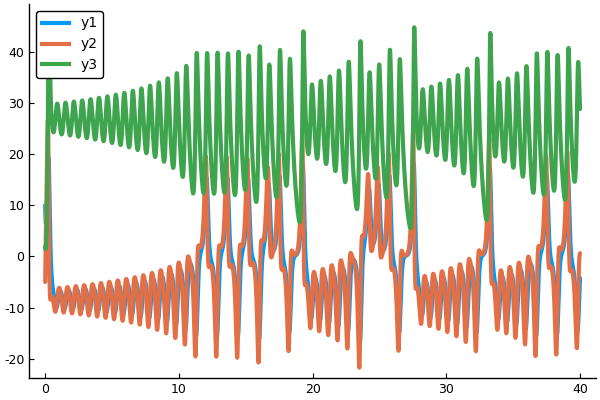

findfont: Font family ['CMU Serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['CMU Serif'] not found. Falling back to DejaVu Sans.


In [7]:
plot(T, hcat(states...)[1,:], linewidth  = 3)
plot!(T, hcat(states...)[2,:], linewidth = 3)
plot!(T, hcat(states...)[3,:], linewidth = 3)

Define propagation function fprop

In [8]:
function (::PropagationFunction)(t::Float64, ENS::EnsembleState{N, TS}) where {N, TS}
    for (i,s) in enumerate(ENS.S)
        
        set_t!(integrator, deepcopy(t))
        set_u!(integrator, deepcopy(s))
        for j=1:50
        step!(integrator)
        end
        ENS.S[i] = deepcopy(integrator.u)

    end
    
    return ENS
end

In [9]:
fprop = PropagationFunction()

PropagationFunction()

Define measurement function m

In [10]:
function (::MeasurementFunction)(t::Float64, s::TS) where TS
    return [s[1]+s[2]+s[3]]
end

In [11]:
function (::MeasurementFunction)(t::Float64) 
    return reshape([1.0, 1.0 , 1.0],(1,3))
end

In [12]:
m = MeasurementFunction()

MeasurementFunction()

Define  real measurement function z, always measure the true state but is corrupted by noise ϵ

In [13]:
function (::RealMeasurementFunction)(t::Float64, ENS::EnsembleState{N, TZ}) where {N, TZ}
    let s = sol(t)
    fill!(ENS, [deepcopy(s[1]+s[2]+s[3])])
    end
    return ENS
end

In [14]:
z = RealMeasurementFunction()

RealMeasurementFunction()

Define covariance inflation

In [15]:
A = MultiAdditiveInflation(3, 1.05, MvNormal(zeros(3), 1.0*I))
# A = IdentityInflation()

MultiAdditiveInflation{3}(1.05, IsoNormal(
dim: 3
μ: [0.0, 0.0, 0.0]
Σ: [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
)
)

Define noise covariance

In [16]:
ϵ = AdditiveInflation(MvNormal(zeros(1), 3.0*I))

AdditiveInflation{1}(IsoNormal(
dim: 1
μ: [0.0]
Σ: [9.0]
)
)

In [17]:
N = 10
NZ = 1
isinflated = true
isfiltered = false
isaugmented = false

false

In [18]:
u0

3-element Array{Float64,1}:
 10.0
 -5.0
  2.0

In [19]:
ens = initialize(N, MvNormal([20.0, -10.0, 10.0], 2.0*I))
estimation_state = [deepcopy(ens.S)]

tmp = deepcopy(u0)
true_state = [deepcopy(u0)]

1-element Array{Array{Float64,1},1}:
 [10.0, -5.0, 2.0]

In [20]:
g = FilteringFunction()

FilteringFunction()

In [26]:
enkf = ENKF(N, NZ, fprop, A, g, m, z, ϵ; isenkf = true, isinflated = isinflated, isfiltered = isfiltered,
    isaugmented = isaugmented);

### Ensemble Kalman filter estimation

In [27]:
Δt = 1e-2
Tsub = 0.0:50*Δt:40.0-50*Δt

@showprogress for (n,t) in enumerate(Tsub)

    global ens
#     enkf.f(t, ens)
    t, ens,_ = enkf(t, 50*Δt, ens)
    push!(estimation_state, deepcopy(ens.S))
    

end

zens = EnsembleState{10,Array{Float64,1}}(Array{Float64,1}[[13.862], [13.862], [13.862], [13.862], [13.862], [13.862], [13.862], [13.862], [13.862], [13.862]])


Progress:   1%|▌                                        |  ETA: 0:03:37

zens = EnsembleState{10,Array{Float64,1}}(Array{Float64,1}[[14.095], [14.095], [14.095], [14.095], [14.095], [14.095], [14.095], [14.095], [14.095], [14.095]])
zens = EnsembleState{10,Array{Float64,1}}(Array{Float64,1}[[11.1982], [11.1982], [11.1982], [11.1982], [11.1982], [11.1982], [11.1982], [11.1982], [11.1982], [11.1982]])
zens = EnsembleState{10,Array{Float64,1}}(Array{Float64,1}[[5.81656], [5.81656], [5.81656], [5.81656], [5.81656], [5.81656], [5.81656], [5.81656], [5.81656], [5.81656]])
zens = EnsembleState{10,Array{Float64,1}}(Array{Float64,1}[[6.82402], [6.82402], [6.82402], [6.82402], [6.82402], [6.82402], [6.82402], [6.82402], [6.82402], [6.82402]])
zens = EnsembleState{10,Array{Float64,1}}(Array{Float64,1}[[11.9463], [11.9463], [11.9463], [11.9463], [11.9463], [11.9463], [11.9463], [11.9463], [11.9463], [11.9463]])
zens = EnsembleState{10,Array{Float64,1}}(Array{Float64,1}[[15.3091], [15.3091], [15.3091], [15.3091], [15.3091], [15.3091], [15.3091], [15.3091], [15.3091], [1

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02



zens = EnsembleState{10,Array{Float64,1}}(Array{Float64,1}[[3.5543], [3.5543], [3.5543], [3.5543], [3.5543], [3.5543], [3.5543], [3.5543], [3.5543], [3.5543]])
zens = EnsembleState{10,Array{Float64,1}}(Array{Float64,1}[[5.21827], [5.21827], [5.21827], [5.21827], [5.21827], [5.21827], [5.21827], [5.21827], [5.21827], [5.21827]])
zens = EnsembleState{10,Array{Float64,1}}(Array{Float64,1}[[24.1065], [24.1065], [24.1065], [24.1065], [24.1065], [24.1065], [24.1065], [24.1065], [24.1065], [24.1065]])
zens = EnsembleState{10,Array{Float64,1}}(Array{Float64,1}[[14.8045], [14.8045], [14.8045], [14.8045], [14.8045], [14.8045], [14.8045], [14.8045], [14.8045], [14.8045]])
zens = EnsembleState{10,Array{Float64,1}}(Array{Float64,1}[[17.7087], [17.7087], [17.7087], [17.7087], [17.7087], [17.7087], [17.7087], [17.7087], [17.7087], [17.7087]])
zens = EnsembleState{10,Array{Float64,1}}(Array{Float64,1}[[19.1447], [19.1447], [19.1447], [19.1447], [19.1447], [19.1447], [19.1447], [19.1447], [19.1447], [

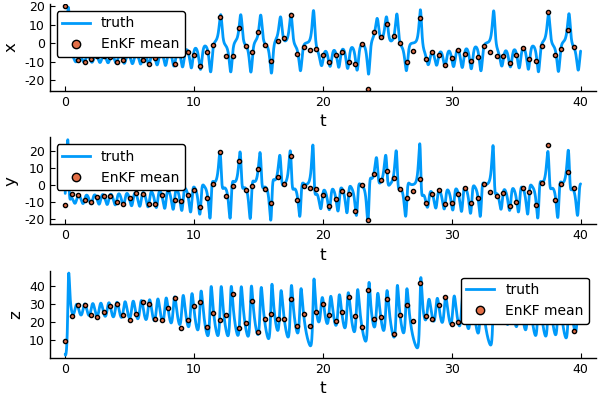

findfont: Font family ['CMU Serif'] not found. Falling back to DejaVu Sans.


In [28]:
s =  hcat(sol(T).u...)
ŝ =  hcat(mean.(estimation_state)...)

plt = plot(layout = (3, 1), legend = true)
plot!(plt[1], T, s[1,1:end], linewidth = 2, label = "truth")
scatter!(plt[1], Tsub, ŝ[1,1:end-1], linewidth = 2, markersize = 3, label = "EnKF mean", xlabel = "t", ylabel = "x", linestyle =:dash)

plot!(plt[2], T, s[2,1:end], linewidth = 2, label = "truth")
scatter!(plt[2], Tsub, ŝ[2,1:end-1], linewidth = 2, markersize = 3, label = "EnKF mean", xlabel = "t", ylabel = "y", linestyle =:dash)

plot!(plt[3], T, s[3,1:end], linewidth = 2, label = "truth")
scatter!(plt[3], Tsub, ŝ[3,1:end-1], linewidth = 2, markersize = 3, label = "EnKF mean", xlabel = "t", ylabel = "z", linestyle =:dash)

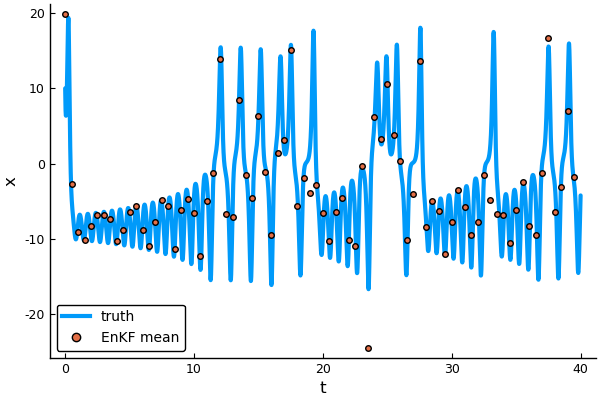

In [29]:
plot(T, s[1,:], linewidth = 3, label = "truth")
# plot!(Tsub, ŝ[1,1:end-1], linewidth = 3, label = "EnKF mean", xlabel = "t", ylabel = "x", linestyle =:dash)
scatter!(Tsub, ŝ[1,1:end-1], linewidth = 3, label = "EnKF mean", xlabel = "t", ylabel = "x", linestyle =:dash)

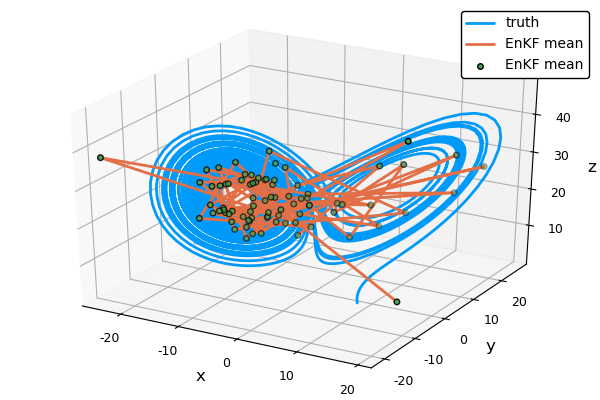

In [30]:
plot(s[1,:], s[2,:], s[3,:], linewidth = 2, label = "truth", legend = true)
plot!(ŝ[1,1:end-1], ŝ[2,1:end-1], ŝ[3,1:end-1], linewidth = 2, label = "EnKF mean", xlabel = "x", 
    ylabel = "y", zlabel ="z", linestyle = :solid)
scatter!(ŝ[1,:], ŝ[2,:], ŝ[3,:], linewidth = 2, label = "EnKF mean", xlabel = "x", 
    ylabel = "y", zlabel ="z", linestyle = :solid)